In [77]:
using Pkg
Pkg.instantiate()
using ITensors
using ITensorTDVP
using Plots
using Observers
using LinearAlgebra
using Plots.PlotMeasures
using LaTeXStrings

In [78]:
N  = 21    # Number of spins
J  = 1.0    # ZZ interaction strength
hx = 1.05   # X-field 
hz = 0.5    # Z-field
δt = 0.05   # Time-step for evolution
β = 0.1    # 1/temp
δβ = β/200   # temp step
T  = 20.0 # Total time
χ  = 32   # Max link dimension allowed
# hx = 0.0   # X-field 
# hz = 0.0
# Δ = 0.05
 

32

In [79]:
sitesext = siteinds("S=1/2",2*N); # Make 2N S=1/2 spin indices defining system + ancilla

In [80]:
# Extract the raising, lowering and identity operators for the extended system:

Sp = ops(sitesext, [("S+", n) for n in 1:(2*N)]);  # Raising operators
Sm = ops(sitesext, [("S-", n) for n in 1:(2*N)]);  # Lowering operators
# ITensors doesn't include the identity operator as standard so construct it:
Id = Vector{ITensor}(undef,2*N)
for i =1:(2*N)
    iv = sitesext[i]
    ID = ITensor(iv', dag(iv));
    for j in 1:ITensors.dim(iv)
        ID[iv' => j, iv => j] = 1.0
    end
    Id[i] = ID
end

In [81]:
# Construct the identity vacuum state:

Ivac = MPS(sitesext, "Up") # All up spins initial state
gates = [(Id[n]*Id[n+1] + Sm[n]*Sm[n+1]) for n in 1:2:(2*N)]; # Maps |00> => |00> + |11>
Ivac = apply(gates, Ivac; cutoff=1e-15); # Note we have no 1/sqrt(2) normalisation

In [82]:
# Define observable for scrambling:
A_op = OpSum()
A_op += 1.0,"Sx",2*floor(Int,N/2+1)-1  # Sx operator in the middle of the system
A = MPO(A_op,sitesext);                # Build the MPO from these terms
Avec = apply(A, Ivac; cutoff=1e-15);   # Compute |A> = A|I>


function local_op(N,sitesext;r) #function used to define local operator to track C(r,t)
    # requirer < floor(Int, N/2) 
    site_index= 2*floor(Int,N/2+1)+2*r-1 #defining site index
    Sx_r_system= op("Sx", sitesext, site_index)
    Sx_r_ancilla= op("Sx", sitesext, site_index+1)
    
    return Sx_r_system, Sx_r_ancilla
end;

In [83]:
# Define function for computing entanglement entropy

function entanglement_entropy(ψ)
    # Compute the von Neumann entanglement entropy across each bond of the MPS
        N = length(ψ)
        SvN = zeros(N)
        psi = ψ
        for b=1:N
            psi = orthogonalize(psi, b)
            if b==1
                U,S,V = svd(psi[b] , siteind(psi, b))
            else
                U,S,V = svd(psi[b], (linkind(psi, b-1), siteind(psi, b)))
            end
            p = diag(S).^2               # Extract square of Schmidt coefficients
            p = p ./ sum(p)              # Normalise to a probability dist
            SvN[b] = -sum(p .* log2.(p)) # Compute Shannon entropy
        end
        return SvN
    end;
    
    # Define function that calulates the commutator 
    function compute_commutator(ψ,Sx_r_system,Sx_r_ancilla)
        Sx_a= apply(Sx_r_system,ψ;cutoff=1e-15)
        a_Sx= apply(Sx_r_ancilla,ψ;cutoff=1e-15)
    
        return Sx_a - a_Sx
    end;

In [84]:
SvN_init = entanglement_entropy(Avec);

In [85]:
# Define observer functions for TDVP:

function current_time(; current_time, bond, half_sweep)
    if bond == 1 && half_sweep == 2
      return real(-im*current_time)
    end
      
    return nothing
end

function measure_SvN(; psi, bond, half_sweep)
if bond == 1 && half_sweep == 2
    return (entanglement_entropy(psi)-SvN_init)
end
return nothing
  end;
  
function measure_linkdim(; psi, bond, half_sweep)
if bond == 1 && half_sweep == 2
    return maxlinkdim(psi)
end
return nothing
end;
  

function measure_commutator(; psi, bond, half_sweep)
Sx_2_system, Sx_2_ancilla= local_op(N,sitesext;r=2)
Sx_4_system, Sx_4_ancilla= local_op(N,sitesext;r=4)
Sx_6_system, Sx_6_ancilla= local_op(N,sitesext;r=6)
Sx_8_system, Sx_8_ancilla= local_op(N,sitesext;r=8)

if bond == 1 && half_sweep == 2
    commutator_2 = compute_commutator(psi, Sx_2_system, Sx_2_ancilla)
    commutator_4 = compute_commutator(psi, Sx_4_system, Sx_4_ancilla)
    commutator_6 = compute_commutator(psi, Sx_6_system, Sx_6_ancilla)
    commutator_8 = compute_commutator(psi, Sx_8_system, Sx_8_ancilla)

    return [real.(inner(commutator_2, commutator_2)), real.(inner(commutator_4, commutator_4)),
            real.(inner(commutator_6, commutator_6)), real.(inner(commutator_8, commutator_8))]

end
return nothing

end;
  
;

In [ ]:
# Perform TDVP evolution of |A(t)>:

obs = Observer("times" => current_time, "SvN" => measure_SvN, "chi" => measure_linkdim,"Commutator"=>measure_commutator)

# Define "Commutator" Hamiltonian operator terms:

# HC = H ⊗ I - I ⊗ H, since H is real and hermitian H = H^T
# staggered B field to XXZ Heisenberg?
H_op = OpSum()
for i=1:2*(N-1)
    H_op += (-1)^(i-1) * J,"Sz",i,"Sz",i+2
end
for i=1:2*N
    H_op += (-1)^(i-1) * hx,"Sx",i
    H_op += (-1)^(i-1) * hz,"Sz",i
end

HC = MPO(H_op,sitesext);

In [ ]:
ψf = tdvp(HC, im*T, Avec; 
          time_step = im*δt,
          normalize = false,
          maxdim = χ,
          cutoff = 1e-10,
          outputlevel=1,
          (observer!)=obs)
# Extract results from time-step observations
times=obs.times
SvN=obs.SvN
chi=obs.chi;
Commutator=obs.Commutator;

In [ ]:
# # per timestep
C_r_t_2 = []
C_r_t_4 = []
C_r_t_6 = []
C_r_t_8 = []
for line in Commutator

    c_2 = (1/(2^N)) * line[1]
    c_4 = (1/(2^N)) * line[2]
    c_6 = (1/(2^N)) * line[3]
    c_8 = (1/(2^N)) * line[4]

    push!(C_r_t_2, c_2)
    push!(C_r_t_4, c_4)
    push!(C_r_t_6, c_6)
    push!(C_r_t_8, c_8)
end;

In [ ]:

min_y = -70

plot(times,log.(C_r_t_2), label="r=2", left_margin=20px)#left_margin = [5mm 0mm]) # ylim=(min_y, 20)
#scatter!(times,log.(C_r_t_2), ylim=(min_y, 20))
plot!(times,log.(C_r_t_4), label="r=4") #!
#scatter!(times,log.(C_r_t_4), ylim=(min_y, 20))
plot!(times,log.(C_r_t_6), label="r=6")
#scatter!(times,log.(C_r_t_6), ylim=(min_y, 20))
plot!(times,log.(C_r_t_8), label="r=8")
#scatter!(times,log.(C_r_t_8), ylim=(min_y, 20))

xlabel!("Time")
ylabel!("log(C(r,t))")

In [86]:
function C_early(r,t; λ=1.9, p=0.67, v_B=0.67)
    bracket = -λ*(((r/v_B)-t)^(1+p))/(t^p)
    return exp(bracket)
end
;

In [87]:
rmin = 40
rmax = 80
rstep = 10
tmin = 5.0
rindex = Int((rmax-rmin)/rstep)
@show rindex
tindex = Int((T-tmin)/δt)
@show tindex
c_arr = zeros(Float64,(rindex,tindex))  

# there are tindex steps of size 0.05, need to map this to indices 1,2,3,.....
;

rindex = 4
tindex = 300


In [98]:
r_arr = collect(range(rmin,rmax,step=rstep))
t_arr = collect(range(tmin,T,step =δt))

for i in CartesianIndices(c_arr)
    j = i[2]
    ii = i[1]
    r = r_arr[ii]
    t = t_arr[j]
    c = C_early(r,t)
    c_arr[i]=c
    
end



In [89]:
c_arr_2 = copy(c_arr)
;


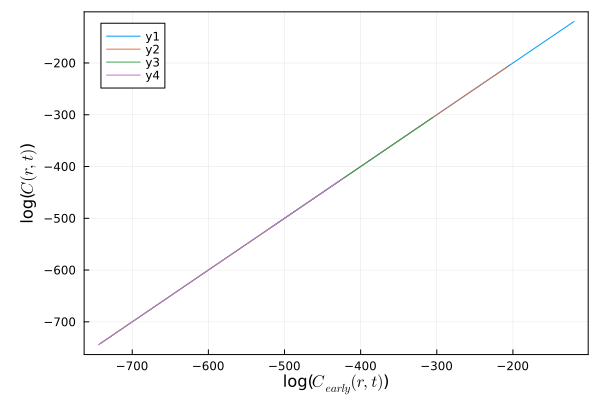

In [96]:
plot(log.(c_arr[1,:]),log.(c_arr_2[1,:]), left_margin=20px, framestyle=:box)
plot!(log.(c_arr[2,:]),log.(c_arr_2[2,:]), left_margin=20px)
plot!(log.(c_arr[3,:]),log.(c_arr_2[3,:]), left_margin=20px)
plot!(log.(c_arr[4,:]),log.(c_arr_2[4,:]), left_margin=20px)

xlabel!(L"log($C_{early}(r,t)$)")
ylabel!(L"log($C(r,t)$)")